'*I cannot imagine any condition which would cause a ship to founder. I cannot conceive of any vital disaster happening to this vessel. Modern ship building has gone beyond that*'.

~Captain Smith

# Titanic - dataset classification

## Introduction

The sinking of the RMS Titanic was one of the biggest and well known maritime tragedy of all time. In 1912 around 1500 passengers died and only about 730 survived.

Although the exact number of passengers, survivors, and victims remains unknown, the Kaggle dataset provides a significant amount of data to analyze.

In the following research, the dataset will be analyzed to see who has the greatest chances of surviving and the machine learning model will be built to predict who could have eventually survived the tragedy.

The dataset with description competition is available on the Kaggle website: https://www.kaggle.com/c/titanic

## Kernel setup

In [1]:
%load_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import sys


sns.set(rc={'figure.figsize': (11.7, 8.27)})
sys.path.append('../')

## Dataset

Dataset provided by Kaggle contains 3 CSV files:

* train.csv - labeled dataset used to train the ML model
* test.csv - dataset without label used to create prediction file
* gender_submission - example submission file

In [2]:
from titanic_classification.load_data import load_data

train_set = load_data('./dataset/', 'train.csv', keep_na=True)
train_set.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The number of features is quite limited - there are 11 features including the label. Some of the columns can be easily ruled-out as will not provide any improvement in the dataset classification - for example ID.

Most columns are self-explaining, but few columns might be a bit more mysterious:

| Name        | Description                                                          |
|-------------|----------------------------------------------------------------------|
| PassangerId | ID of the passenger                                                  |
| Survived    | Boolean value (1 = survived, 0 = died)                               |
| Pclass      | Class of cabin (1 = first, 2 = second, 3 = third)                    |
| Name        | Name of passenger                                                    |
| Sex         | Sex                                                                  |
| Age         | Age                                                                  |
| SibSp       | Number of siblings/spouses aboard on Titanic                         |
| Parch       | Number of parents/children aboard on Titanic                         |
| Ticket      | Ticket number                                                        |
| Cabin       | Cabin number                                                         |
| Embarked    | Port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton) |

In [5]:
train_set.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### Missing values

As seen in the beginning, there are some rows without needed data. Those will have to be handled during dataset preparation.

In [15]:
train_set.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [74]:
test_set.isnull().sum()

PassengerId          0
Pclass               0
Name                 0
Sex                  0
Age                  0
SibSp                0
Parch                0
Ticket               0
Fare                 1
Cabin              327
Embarked             0
Relatives            0
Traveling_alone      0
Title                0
dtype: int64

## Insight

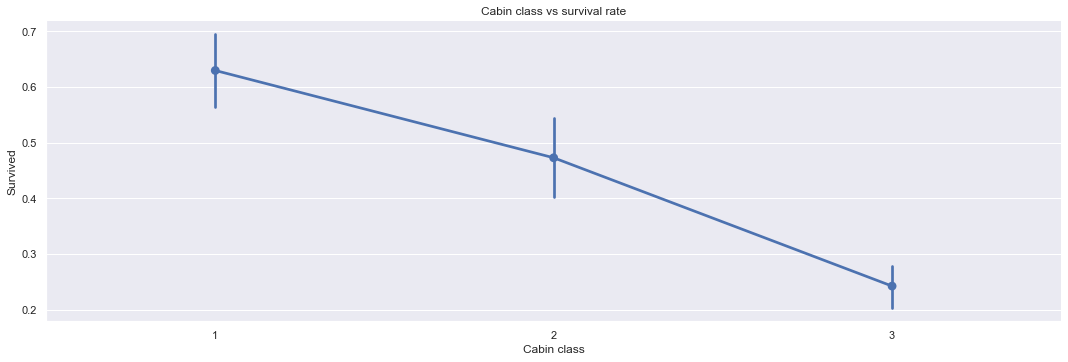

In [46]:
sns.catplot('Pclass', 'Survived', data=train_set, aspect=3, kind="point")
plt.title('Cabin class vs survival rate')
plt.xlabel('Cabin class');

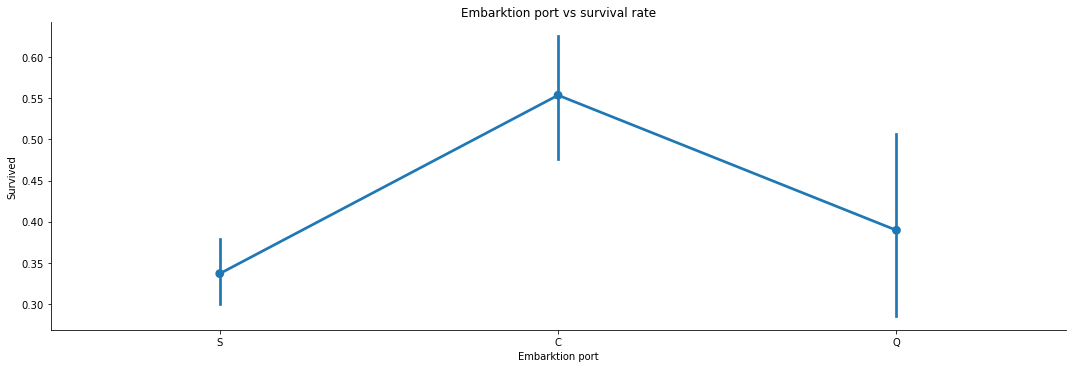

In [4]:
sns.catplot('Embarked', 'Survived', data=train_set, aspect=3, kind="point")
plt.title('Embarktion port vs survival rate')
plt.xlabel('Embarktion port');

The port where passengers embarked on the ship has a big impact on the survival rate - passengers that went aboard in Cherbourg had statistically higher chances of survival. This might be related to the fact that the latter passengers boarded the ship, the lower deck they were assigned to. This applies especially to the second and third class.

    Comparing the correlation between the cabin class and survival rate is probably the most interesting bit. It is not a surprise that the higher class passenger had, the higher the chances of survival were.

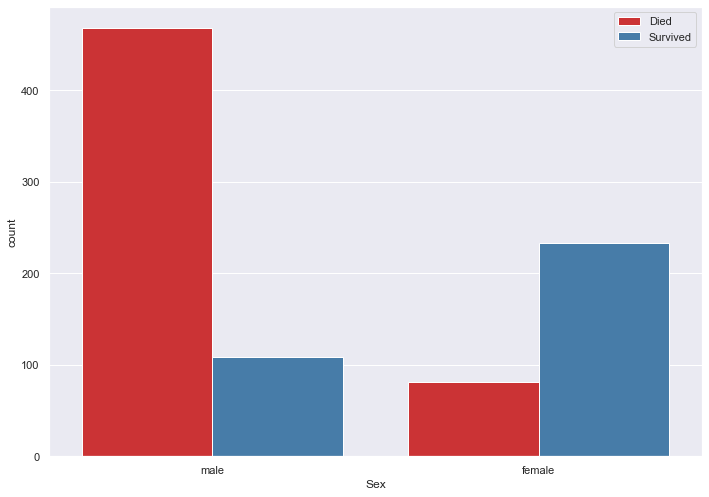

In [49]:
sex_survived_barplot = sns.countplot(x = 'Sex', hue = 'Survived', palette = 'Set1', data = train_set)
sex_survived_barplot.legend(labels=['Died', 'Survived']);

The vast majority of victims were males that did not survive the tragedy. The highest amount of victims that survived the tragedy were females.

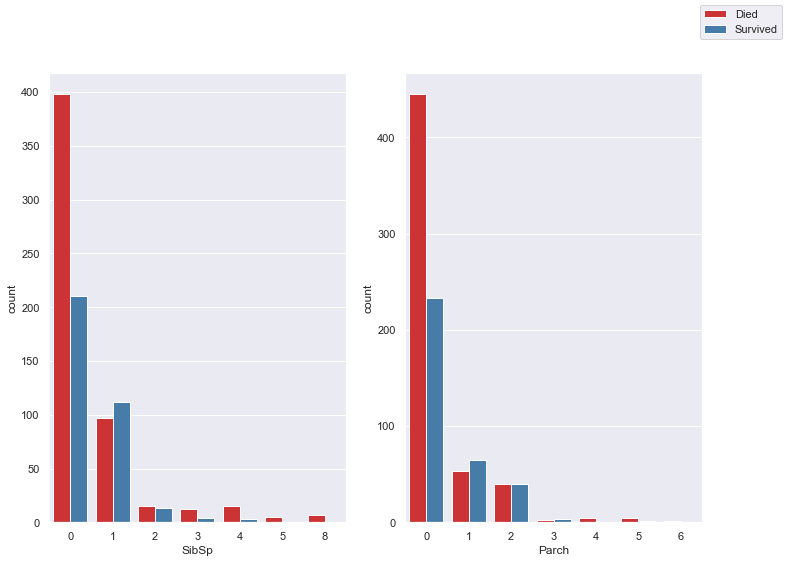

In [50]:
fig, ax = plt.subplots(1,2)
sibsp_barplot = sns.countplot(x = 'SibSp', hue = 'Survived', palette = 'Set1', data = train_set, ax=ax[0])
parch_barplot = sns.countplot(x = 'Parch', hue = 'Survived', palette = 'Set1', data = train_set, ax=ax[1])
sibsp_barplot.legend_.remove()
parch_barplot.legend_.remove()
fig.legend(labels=['Died','Survived']);

In the above chart, the number of siblings and parents of the passengers has been summed and compared to the number of people that survived the tragedy.

The highest chances of surviving had people with one relative on board, the second-highest chances had people with 2 relatives on-board. People with no or 3 relatives had statistically the same chances of surviving.

Finally, the lowest chances of surviving had passengers with 4 or more relatives on board.

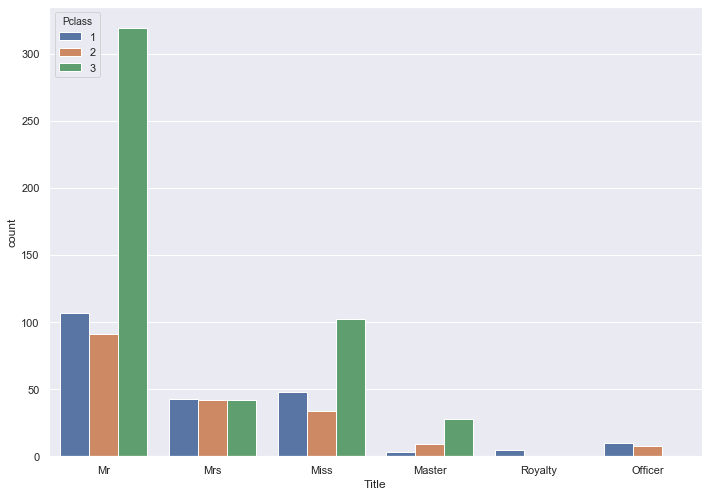

In [5]:
from titanic_classification.title_selector import TitleSelector


title_selector = TitleSelector()
train_set_titles = title_selector.transform(train_set)

sns.countplot(x='Title', hue='Pclass', data=train_set_titles);

The title is correlated with the class the passenger travelled in. Royalty and Officer people travelled exclusively with first and both - first and second class respectively.

Interestingly, passengers with the title 'Mrs' were equally distributed among all three cabin classes.

The vast majority of people travelled mostly in third class as one could expect.

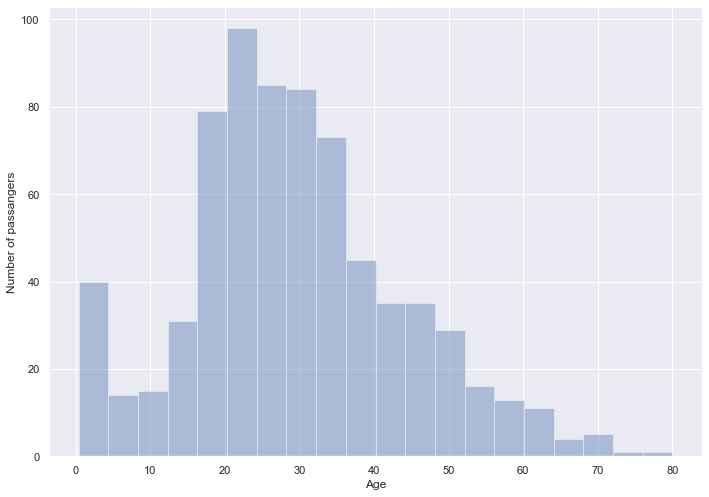

In [6]:
distplot_age = sns.distplot(train_set['Age'].dropna(), kde=False, bins=20)
distplot_age.set(xlabel='Age', ylabel='Number of passangers');

C:\Users\User\.virtualenvs\ml-dataset-analysis-eKEAK5HG\lib\site-packages\datawig\imputer.py:822: FutureWarning: The 'contains' method is deprecated and will be removed in a future version. Use 'key in index' instead of 'index.contains(key)'
  if data_frame.columns.contains(imputation_col):


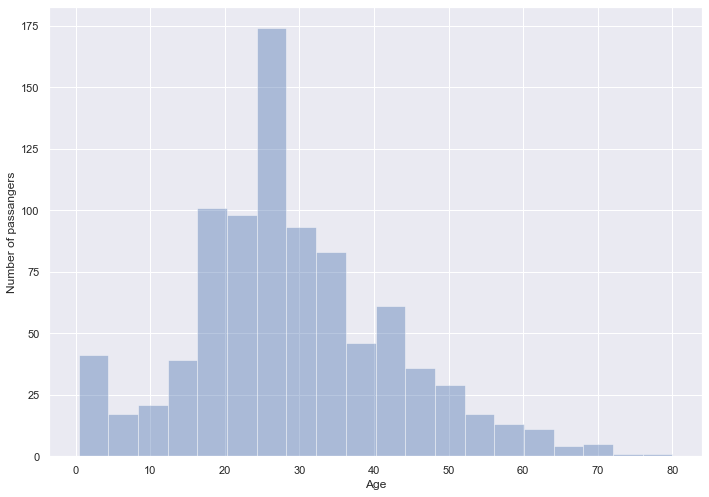

In [7]:
from titanic_classification.age_imputer import AgeImputer


age_imputer = AgeImputer()
train_set_ages = age_imputer.transform(train_set_titles)
distplot_age_filled = sns.distplot(train_set_ages['Age'], kde=False, bins=20)
distplot_age_filled.set(xlabel='Age', ylabel='Number of passangers');

Ages with computed data still look like a proper Gaussian distribution, although there are small anomalies. For instance, a big number of young children (younger than 5 years) and a significant number of people aged 25 - 30.

## Preparing data

### Introduction


A significant amount of columns contain categorical/enum values - i.e. code of type string that has a specific meaning. Whereas it might be helpful for human, it makes the computation unnecessarily expensive. In the following section, the dataset will be prepared for later analysis.

### Transformation pipeline

Specifically:

1. The id should be removed as not relevant for training purposes

2. N/A/Empty values should be populated to avoid mathematical operations on empty cells/null data

3. Discrete columns should be transformed

4. The title should be extracted from the name and transformed into discrete value

5. Number of relatives should be summed to construct one column instead of two

6. New boolean feature to construct - Birkenhead Drill - i.e. 'Ladies and children first'

7. Add new feature - the sum of SibSp and Parch

8. Age values should be converted to bins

9. Add new feature - indicator whether passenger travelled alone or not

10. Add new feature - Deck


In [183]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

from titanic_classification.title_selector import TitleSelector
from titanic_classification.relatives_column_creator import RelativesColumnCreator
from titanic_classification.dataframe_simple_imputer import DataFrameSimpleImputer
from titanic_classification.label_remover import LabelRemover
from titanic_classification.birkenhead_drill import BirkenheadDrill
from titanic_classification.age_imputer import AgeImputer
from titanic_classification.deck_imputer import DeckImputer
from titanic_classification.age_binizer import AgeBinizer
from titanic_classification.traveling_alone_creator import TravelingAloneCreator


discrete_columns = ['Sex', 'Embarked', 'Title']
num_columns = ['PassengerId', 'Age', 'SibSp', 'Parch', 'Fare', 'Pclass', 'BirkenheadDrill']
txt_columns = ['Name', 'Ticket', 'Cabin']

txt_pipeline = Pipeline([
    ('id_rmv', LabelRemover(txt_columns))
])

num_pipeline = Pipeline([
    ('id_rmv', LabelRemover(['PassengerId'])),
    ('imputer', DataFrameSimpleImputer({'strategy':"median"}))
])

cat_pipeline = Pipeline([
    ('imputer', DataFrameSimpleImputer({'strategy':"most_frequent"})),
    ('vectorizer', ColumnTransformer([
        ('ordinal', OrdinalEncoder(), ['Embarked', 'Title']),
        ('1hot', OneHotEncoder(), ['Sex'])
    ]))
])

col_pipeline = ColumnTransformer(
    transformers = [
        ('txt', txt_pipeline, txt_columns),
        ('num', num_pipeline, num_columns),
        ('cat', cat_pipeline, discrete_columns)
    ])

prep_pipeline = Pipeline(steps=[
    ('relatives_creator', RelativesColumnCreator()),
    ('travel_alone_selector', TravelingAloneCreator()),
    ('title_selector', TitleSelector()),
    ('age_imputer', AgeImputer()),
    ('age_bin', AgeBinizer()),
    ('birkenhead_drill', BirkenheadDrill()),
    ('deck_imputer', DeckImputer()),
    ('preprocessor', col_pipeline)
])

### Transforming data

In [184]:
train_set_unlabelled = train_set.drop(columns='Survived')

prep_train_set = prep_pipeline.fit_transform(train_set_unlabelled)
print(f'Size of prepared train set: {np.shape(prep_train_set)}')

C:\Users\User\.virtualenvs\ml-dataset-analysis-eKEAK5HG\lib\site-packages\datawig\imputer.py:822: FutureWarning: The 'contains' method is deprecated and will be removed in a future version. Use 'key in index' instead of 'index.contains(key)'
  if data_frame.columns.contains(imputation_col):
C:\Users\User\.virtualenvs\ml-dataset-analysis-eKEAK5HG\lib\site-packages\sklearn\metrics\_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Size of prepared train set: (891, 10)


C:\Users\User\.virtualenvs\ml-dataset-analysis-eKEAK5HG\lib\site-packages\datawig\calibration.py:92: RuntimeWarning: divide by zero encountered in log
  return np.log(probas)
C:\Users\User\.virtualenvs\ml-dataset-analysis-eKEAK5HG\lib\site-packages\datawig\imputer.py:822: FutureWarning: The 'contains' method is deprecated and will be removed in a future version. Use 'key in index' instead of 'index.contains(key)'
  if data_frame.columns.contains(imputation_col):
C:\Users\User\.virtualenvs\ml-dataset-analysis-eKEAK5HG\lib\site-packages\datawig\imputer.py:829: FutureWarning: The 'contains' method is deprecated and will be removed in a future version. Use 'key in index' instead of 'index.contains(key)'
  if data_frame.columns.contains(imputation_proba_col):


## Machine learning models

### Introduction

After careful data preparation, a number of ML models can be used to train using the prepared training data set.

Accordingly, to lunch free theorem there is no one perfect model that will serve the purpose perfectly. Rather one needs to check multiple solutions and select the most promising one.

### Preparation

In [190]:
from sklearn.model_selection import train_test_split


train_label = train_set['Survived']
X_train, X_test, Y_train, Y_test = train_test_split(prep_train_set, train_label, test_size=0.2, random_state=42)
print(f'''
Size of train set: {np.shape(X_train)}
Size of test set: {np.shape(X_test)}
Size of train label vector: {np.shape(Y_train)}
Size of test label vector: {np.shape(Y_test)}
''')


Size of train set: (712, 10)
Size of test set: (179, 10)
Size of train label vector: (712,)
Size of test label vector: (179,)



### Models comparison

                    Classifier  Accurracy   CV Mean     Score
7   GradientBoostingClassifier   0.832402  0.834236  0.904494
4       RandomForestClassifier   0.826816  0.814616  0.952247
5         ExtraTreesClassifier   0.821229  0.800581  0.952247
6           AdaBoostClassifier   0.804469  0.830040  0.853933
2              RidgeClassifier   0.787709  0.789294  0.792135
3            RidgeClassifierCV   0.776536  0.783699  0.792135
0                SGDClassifier   0.759777  0.725933  0.717697
1  PassiveAggressiveClassifier   0.670391  0.734482  0.688202


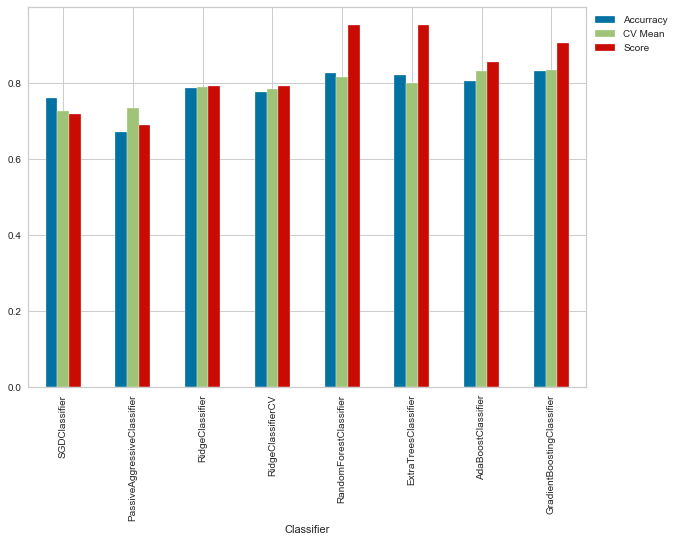

In [201]:
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import RidgeClassifierCV
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from pandas import DataFrame

classifiers = {
    'SGDClassifier': SGDClassifier(),
    'PassiveAggressiveClassifier': PassiveAggressiveClassifier(),
    "RidgeClassifier": RidgeClassifier(normalize=True),
    'RidgeClassifierCV': RidgeClassifierCV(),
    'RandomForestClassifier': RandomForestClassifier(),
    'ExtraTreesClassifier': ExtraTreesClassifier(),
    'AdaBoostClassifier': AdaBoostClassifier(),
    'GradientBoostingClassifier': GradientBoostingClassifier()
}

columns = ['Classifier', 'Accurracy', 'CV Mean', 'Score']
df_scores = DataFrame(columns=columns)

for name, clf in classifiers.items():
    clf.fit(X_train, Y_train)
    Y_predicted = clf.predict(X_test)
    acc_score = accuracy_score(Y_test, Y_predicted)
    cv_mean = np.mean(cross_val_score(clf, X_train, Y_train, cv=5))
    df_row = DataFrame([[name, acc_score, cv_mean, clf.score(X_train, Y_train)]],columns=columns)
    df_scores = df_scores.append(df_row, ignore_index=True)

print(df_scores.sort_values('Accurracy', ascending=False))
df_scores.plot.bar(x='Classifier', figsize=(10,7)).legend(bbox_to_anchor=(1, 1));

The highest overall score was achieved by Random Forest Classifier with 0.95, the accuracy of 0.83 and CV mean equal to 0.82.

The next, most promising classifiers are Gradient Boosting Classifier and AdaBoostClassifier.

All three models will be combined using VotingClassifier to provide more reliable predictions.

### Misclassification analysis

In [202]:
Y_predicted = classifiers['RandomForestClassifier'].predict(X_test)
misclassified_indices = Y_test[Y_test != Y_predicted].index
wrongly_predicted = train_set.iloc[[*misclassified_indices]]
wrongly_predicted['Predicted'] = 1 - wrongly_predicted['Survived']
wrongly_predicted.head(5)

C:\Users\User\.virtualenvs\ml-dataset-analysis-eKEAK5HG\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Predicted
39,40,1,3,"Nicola-Yarred, Miss. Jamila",female,14.0,1,0,2651,11.2417,NaN,C,0
621,622,1,1,"Kimball, Mr. Edwin Nelson Jr",male,42.0,1,0,11753,52.5542,D19,S,0
192,193,1,3,"Andersen-Jensen, Miss. Carla Christine Nielsine",female,19.0,1,0,350046,7.8542,NaN,S,0
673,674,1,2,"Wilhelms, Mr. Charles",male,31.0,0,0,244270,13.0000,NaN,S,0
396,397,0,3,"Olsson, Miss. Elina",female,31.0,0,0,350407,7.8542,NaN,S,1


The model makes some mistakes in its predictions, but there cases where the misclassification outcome is understandable.

## Learning Curve

### Random Forest

C:\Users\User\.virtualenvs\ml-dataset-analysis-eKEAK5HG\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


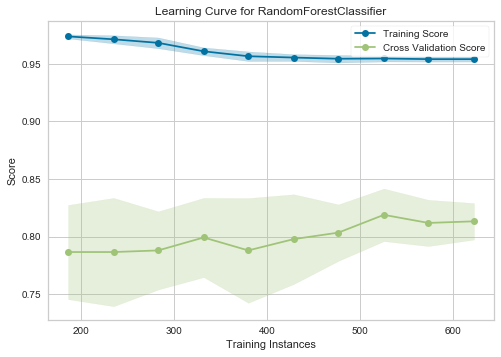

In [204]:
from sklearn.model_selection import StratifiedKFold
from yellowbrick.model_selection import LearningCurve


rf_clf = RandomForestClassifier()
sizes = np.linspace(0.3, 1.0, 10)
cv = StratifiedKFold(n_splits=8)

visualizer = LearningCurve(rf_clf, cv=cv, scoring='accuracy', train_sizes=sizes)
visualizer.fit(X_train, Y_train)
visualizer.show();

The learning curve for Random Forest Classifier might look like it is not performing better over time, but in fact, it does not make too much sense doing learning curve check for RFC. The training data goes through the same paths all the time, so although the plot might suggest underfitting the classifier performs correctly. 

### Gradient Boosting

C:\Users\User\.virtualenvs\ml-dataset-analysis-eKEAK5HG\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


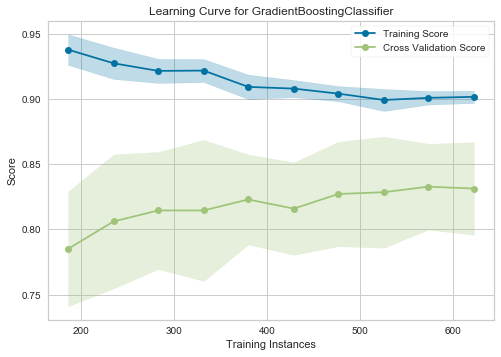

In [205]:
from sklearn.model_selection import StratifiedKFold
from yellowbrick.model_selection import LearningCurve


gb_clf = GradientBoostingClassifier()
sizes = np.linspace(0.3, 1.0, 10)
cv = StratifiedKFold(n_splits=8)

visualizer = LearningCurve(gb_clf, cv=cv, scoring='accuracy', train_sizes=sizes)
visualizer.fit(X_train, Y_train)
visualizer.show();

Learning curve graph for Gradient Boosting Classifier shows the overall improvement over time. The algorithm converges until about 600 dataset example and then remains steady. Adding more training examples would not improve the overall performance.

### ADA Boost Classifier

C:\Users\User\.virtualenvs\ml-dataset-analysis-eKEAK5HG\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


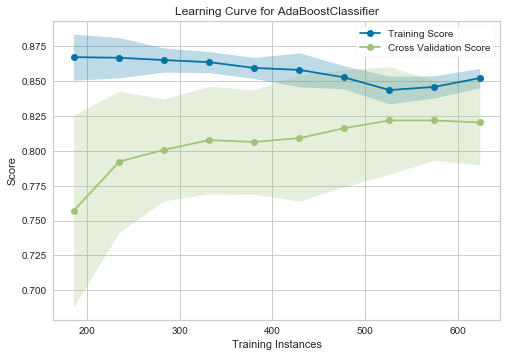

In [206]:
from sklearn.model_selection import StratifiedKFold
from yellowbrick.model_selection import LearningCurve


ab_clf = AdaBoostClassifier()
sizes = np.linspace(0.3, 1.0, 10)
cv = StratifiedKFold(n_splits=8)

visualizer = LearningCurve(ab_clf, cv=cv, scoring='accuracy', train_sizes=sizes)
visualizer.fit(X_train, Y_train)
visualizer.show();

Learning curve graph for ADA Boost Classifier looks even better than the previous one - the classifier is learning up to ~520 training set and then converges. The plot suggests that similarly to previous classifiers adding more training examples would not help.

### Random Forest Classifier tuning

In [185]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


rf_clf = RandomForestClassifier()
param_grid = {
    'criterion': ['gini'],
    'max_features': range(6, 11),
    'n_estimators': [420, 500, 600, 700, 800],
    'class_weight': ['balanced', 'balanced_subsample', None],
    'ccp_alpha': [.002, .003, .005]
}
grid_search = GridSearchCV(estimator=rf_clf, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(prep_train_set, train_label)

best_rf_clf = grid_search.best_estimator_
best_rf_params = grid_search.best_params_
best_rf_params

{'ccp_alpha': 0.002,
 'class_weight': None,
 'criterion': 'gini',
 'max_features': 7,
 'n_estimators': 600}

### ADA Boost classifier tuning

In [186]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV


ada_clf = AdaBoostClassifier()
param_grid = [
    {
        'n_estimators': [400, 420, 500, 600, 1000, 1100, 1200],
        'learning_rate': [.003, .005, .006, .008],
        'algorithm': ['SAMME', 'SAMME.R']
    }
]
grid_search = GridSearchCV(estimator=ada_clf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(prep_train_set, train_label)

best_ada_clf = grid_search.best_estimator_
best_ada_params = grid_search.best_params_
best_ada_params

{'algorithm': 'SAMME.R', 'learning_rate': 0.008, 'n_estimators': 1100}

### Gradient Boosting Classifier tuning

In [187]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV


gb_clf = GradientBoostingClassifier(verbose=True)
param_grid = {
    'loss': ['deviance', 'exponential'],
    'learning_rate': [.1, .2, .5, 1],
    'min_samples_leaf': range(1, 6),
    'min_samples_split': range(2, 6),
    'max_depth': range(2, 10)
}
grid_search = GridSearchCV(estimator=gb_clf, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(prep_train_set, train_label)

best_gb_clf = grid_search.best_estimator_
best_gb_params = grid_search.best_params_
best_gb_params

      Iter       Train Loss   Remaining Time 
         1           0.8830            1.55s
         2           0.8149            0.77s
         3           0.7632            0.51s
         4           0.7235            0.37s
         5           0.6930            0.30s
         6           0.6699            0.24s
         7           0.6506            0.36s
         8           0.6355            0.36s
         9           0.6220            0.32s
        10           0.6104            0.32s
        20           0.5418            0.20s
        30           0.5037            0.15s
        40           0.4656            0.12s
        50           0.4419            0.09s
        60           0.4167            0.07s
        70           0.4005            0.05s
        80           0.3784            0.04s
        90           0.3647            0.02s
       100           0.3484            0.00s


{'learning_rate': 0.2,
 'loss': 'exponential',
 'max_depth': 4,
 'min_samples_leaf': 5,
 'min_samples_split': 2}

## Ensemble Learning

In [197]:
from sklearn.ensemble import VotingClassifier


voting_clf = VotingClassifier(estimators=[
            ('rf_clf', best_rf_clf),
            ('ada_clf', best_ada_clf),
            ('gb_clf', best_gb_clf)],
            voting='soft')
voting_clf = voting_clf.fit(prep_train_set, train_label)

      Iter       Train Loss   Remaining Time 
         1           0.8830            0.00s
         2           0.8150            0.00s
         3           0.7632            0.00s
         4           0.7236            0.00s
         5           0.6930            0.00s
         6           0.6699            0.00s
         7           0.6507            0.00s
         8           0.6357            0.00s
         9           0.6221            0.16s
        10           0.6105            0.14s
        20           0.5418            0.06s
        30           0.5042            0.07s
        40           0.4676            0.07s
        50           0.4435            0.06s
        60           0.4250            0.05s
        70           0.4003            0.03s
        80           0.3843            0.02s
        90           0.3675            0.01s
       100           0.3534            0.00s


## Submission

### Introduction

As part of the competition, Kaggle provides a test CSV file that should be used to generate a CSV file with 2 columns - PassengerId and Survival.

In [192]:
from titanic_classification.load_data import load_data


test_set = load_data('./dataset', 'test.csv', keep_na=True)
test_set.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


### Preparation

In [193]:
prep_test_set = prep_pipeline.fit_transform(test_set)

C:\Users\User\.virtualenvs\ml-dataset-analysis-eKEAK5HG\lib\site-packages\datawig\calibration.py:92: RuntimeWarning: invalid value encountered in log
  return np.log(probas)
C:\Users\User\.virtualenvs\ml-dataset-analysis-eKEAK5HG\lib\site-packages\datawig\calibration.py:59: RuntimeWarning: invalid value encountered in greater_equal
  bin_mask = (top_probas >= bin_lower) & (top_probas < bin_upper)
C:\Users\User\.virtualenvs\ml-dataset-analysis-eKEAK5HG\lib\site-packages\datawig\calibration.py:59: RuntimeWarning: invalid value encountered in less
  bin_mask = (top_probas >= bin_lower) & (top_probas < bin_upper)
C:\Users\User\.virtualenvs\ml-dataset-analysis-eKEAK5HG\lib\site-packages\datawig\imputer.py:822: FutureWarning: The 'contains' method is deprecated and will be removed in a future version. Use 'key in index' instead of 'index.contains(key)'
  if data_frame.columns.contains(imputation_col):
C:\Users\User\.virtualenvs\ml-dataset-analysis-eKEAK5HG\lib\site-packages\sklearn\metrics\_

### Prediction

In [194]:
test_Y_predicted = voting_clf.predict(prep_test_set)

### Submission

In [195]:
import pandas as pd


predicted_survivors = pd.DataFrame({
    'PassengerId': test_set['PassengerId'],
    'Survived': test_Y_predicted
})

predicted_survivors.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


### Saving / Exporting

In [196]:
from titanic_classification.export_csv import export_csv


export_csv(predicted_survivors, 'submission')

The best score I managed to achieve with this ML model was 0.80382 (~80.4% of accuracy) which ranks in the top 9% of all submissions on Kaggle.